In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
import json
from datetime import datetime, date, time

## Loading of the different datasets

In [ ]:
#Load character metadata
characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
characters.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
characters.head()

In [ ]:
#Load movie metadata
mov = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
mov.columns = ['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
mov.head()

In [4]:
#Load character names used in at least 2 different movies 
name_clusters = pd.read_table('Data/MovieSummaries/name.clusters.txt',header=None)#,sep=" ",header=None)
name_clusters.columns = ['character_name','freebase_char/actor_map_ID']

In [ ]:
#Load plot summaries
plot_summaries = pd.read_table('Data/MovieSummaries/plot_summaries.txt',header=None)
plot_summaries.columns = ['wiki_movie_ID','movie_plot']
plot_summaries.head()

In [ ]:
#Load tvtropes
type_char = pd.read_table('Data/MovieSummaries/tvtropes.clusters.txt',header=None)
type_char.columns = ['char_type','infos']
type_char.head()

## Differences in age and height between male and female characters

> We want to compare different features between roles played by male or female. 

### Evaluating and filtering out missing values

In [7]:
#Create a DataFrame keeping only characters where actors have reported gender
characters_gender = characters[characters["actor_gender"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains {} rows.'.format(len(characters_gender) / len(characters), len(characters_gender)))

 89.9% of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains 405060 rows.


In [8]:
#What are the possible different values for characters_gender? 
pd.Categorical(characters_gender.actor_gender)

['F', 'F', 'M', 'M', 'F', ..., 'F', 'M', 'F', 'M', 'M']
Length: 405060
Categories (2, object): ['F', 'M']

### What is the repartition between male and female characters? 

66.72% of reported characters are played by male actors.


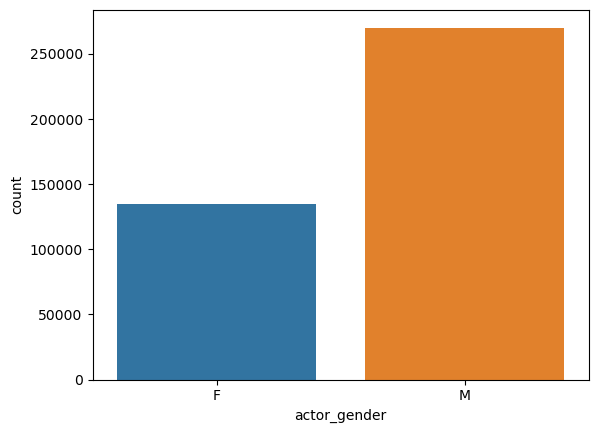

In [49]:
#Create two DataFrame for characters played by female/male
characters_female = characters_gender[characters_gender['actor_gender']== 'F']
characters_male = characters_gender[characters_gender['actor_gender']== 'M']

#Plot the repartition
sns.countplot(x = characters_gender['actor_gender'])

print("{:.2%} of reported characters are played by male actors.".format(len(characters_male)/len(characters_gender)))

### How is age of male characters compared to age of male characters? 

> We want to compare **age** of the actors and actresses palying roles reported in *character*. 

In [10]:
#Clear out characters_gender where age is not reported (characters_gender_age)
characters_gender_age = characters_gender[characters_gender["actor_age_movie"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains {} rows.'.format(len(characters_gender_age) / len(characters), len(characters_gender_age)))

 64.5% of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains 290770 rows.


> We first explore and clean the data. 

In [11]:
characters_gender_age.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,2.907700e+05,139639.000000,290770.000000
mean,1.302929e+07,1.789524,37.804148
std,1.080402e+07,4.380801,20.616015
min,3.300000e+02,0.610000,-7896.000000
25%,3.052538e+06,1.680000,28.000000
50%,1.014264e+07,1.750000,36.000000
75%,2.261175e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


> The negative values do not make sense: we filter them out.

In [12]:
characters_gender_age = characters_gender_age[characters_gender_age['actor_age_movie'] >= 0]

Text(0, 0.5, 'Age')

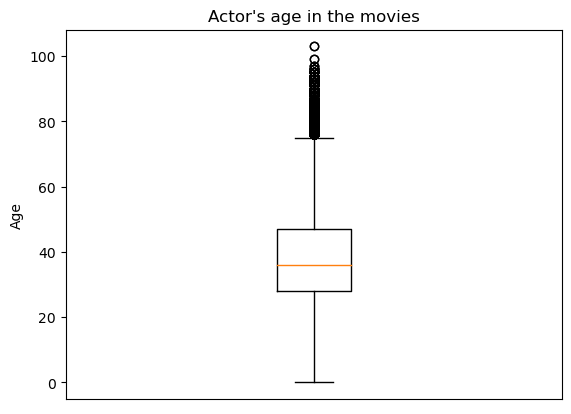

In [13]:
plt.boxplot(characters_gender_age['actor_age_movie'])
plt.xticks([])
plt.title("Actor's age in the movies")
plt.ylabel("Age")

> We can visualize age of actors by gender. 

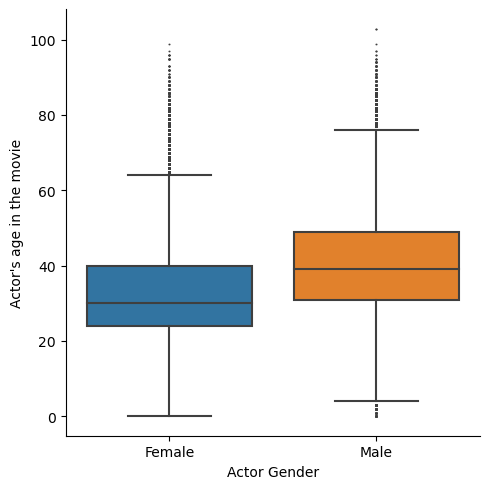

In [15]:
g = sns.catplot(data=characters_gender_age, x="actor_gender", y="actor_age_movie", kind="box", fliersize=0.5)
g.set_axis_labels("Actor Gender", "Actor's age in the movie")
g.set_xticklabels(["Female", "Male"])

### How about height? 

> We can perform the same analysis for height. 

In [60]:
# Clear out characters_gender where height is not reported (characters_gender_age)
characters_gender_height = characters_gender[characters_gender["actor_height"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains {} rows.'.format(len(characters_gender_height) / len(characters), len(characters_gender_height)))

 34.3% of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains 154663 rows.


In [103]:
characters_gender_height.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,1.546630e+05,154663.000000,139639.000000
mean,1.212276e+07,1.788966,37.301671
std,1.076543e+07,4.382216,13.890925
min,3.217000e+03,0.610000,-57.000000
25%,2.511602e+06,1.676400,27.000000
50%,8.627638e+06,1.750000,35.000000
75%,2.107084e+07,1.830000,46.000000
max,3.750192e+07,510.000000,96.000000


> 510 cm seems to be a corrupted value. We filter rows where height is above 2,72m (biggest height reported).

In [109]:
characters_gender_height = characters_gender_height[characters_gender_height['actor_height'] < 2.73]

> Are there other outliers? 

Text(0, 0.5, 'Height (cm)')

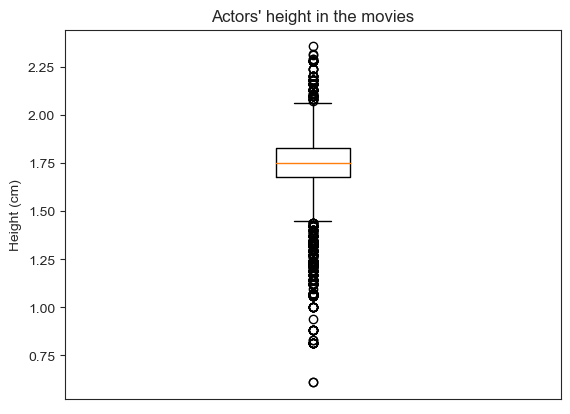

In [110]:
plt.boxplot(characters_gender_height['actor_height'])
plt.xticks([])
plt.title("Actors' height in the movies")
plt.ylabel("Height (cm)")

> We can visualize height by gender. 

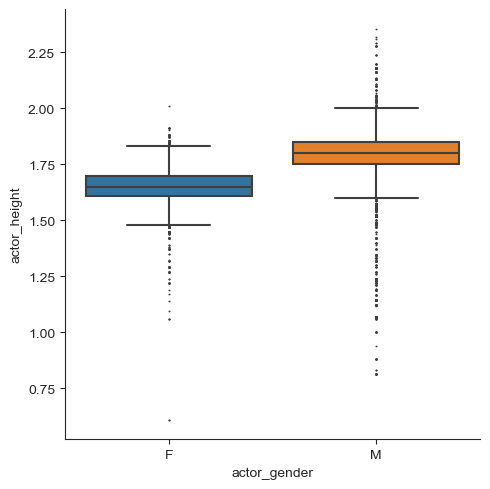

In [111]:
sns.catplot(data=characters_gender_height, x="actor_gender", y="actor_height", kind="box", fliersize=0.5)

> It seems that male characters have more outliers than female characters. 

### Are the observed differences statistically significant? 

> We look at average age and height between male and female characters. 

In [11]:
#In the movies where characters are reported, actresses are on average smaller and younger than men 
characters_gender_grouped = characters_gender.groupby("actor_gender")[["actor_gender", "actor_age_movie", "actor_height"]].mean()
characters_gender_grouped.head()

,actor_age_movie,actor_height
actor_gender,,
F,32.810753,1.659008
M,40.391679,1.863798


> Are these differences statistically significant? \
> To answer this question, we perform an independent sample t-test under the null hypothesis: there is no difference between actors' and actresses'a age. 

In [65]:
# We first extract rows where character is played by a woman or by a man
characters_female_age = characters_gender_age[characters_gender_age['actor_gender']== 'F']
characters_male_age = characters_gender_age[characters_gender_age['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_age)/len(characters_gender_age)))
print("The DataFrame characters_female_age has {} rows, characters_male_age has {} rows.".format(len(characters_female_age), len(characters_male_age)))

65.87% of characters were gender and age are reported are male.
The DataFrame characters_female_age has 99246 rows, characters_male_age has 191524 rows.


In [68]:
#characters_female and characters_male do not have the same shape, we extract 99 242 rows from characters_male to have the same shape to perform an independent t-test
characters_male_age_corr = characters_male_age.sample(n=len(characters_female_age), replace=False)

#We perform the independent sample t-test to compare age of female and male actors
stat_indep_age, pvalue_indep_age = stats.ttest_ind(characters_female_age['actor_age_movie'], characters_male_age_corr['actor_age_movie'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_age))

The p-value for the independent sample t-test is: 0.0


>Here, the p-value is probably below a certain treshold and Pyhton returns 0. \
>As the p-value verifies $ p < 0.05 $, actresses are significantly younger in movies of the dataset than actors, with 95% confidence. 

In [72]:
#We now do the same t-test to compare height of male and female actors
characters_female_height = characters_gender_height[characters_gender_height['actor_gender']== 'F']
characters_male_height = characters_gender_height[characters_gender_height['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_height)/len(characters_gender_height)))
print("The DataFrame characters_female has {} rows, characters_male has {} rows.".format(len(characters_female_height), len(characters_male_height)))

63.46% of characters were gender and age are reported are male.
The DataFrame characters_female has 56515 rows, characters_male has 98148 rows.


In [73]:
#characters_female and characters_male do not have the same shape, we extract 56 515 rows from characters_male to have the same shape to perform an independent t-test
characters_male_corr2 = characters_male_height.sample(n=len(characters_female_height), replace=False)

#We perform the independent sample t-test to compare age of female and male actors
stat_indep_height, pvalue_indep_height = stats.ttest_ind(characters_female_height['actor_height'], characters_male_corr2['actor_height'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_height))

The p-value for the independent sample t-test is: 1.969864070783097e-20


>Here again the p-value verifies $ p < 0.05 $ so actresses are significantly smaller in movies of the dataset than actors, with 95% confidence. 

### Is there a correlation between age and gender, or between height and gender? 